Using device: cuda
Oil Price LSTM Binary Classification: 70/10/20 Time Split | Validation Set Early Stop/Threshold (No Test Leakage)

1. Loading and preprocessing data...
Data shape: (2503, 3)
Price range: 8.91 - 123.64
Up samples: 1288, Down samples: 1151, Small moves/No labels: 64

2. Preparing training/validation/test data (avoiding leakage)...
Creating simplified features (3)...
Skipped 61 small moves/unlabeled samples (|future 1-day return| ≤ 0.050%)

Data preparation completed:
Number of features: 3 (ret_1d, ma_ratio, vol_10)
Training set: X_train (1695, 20, 3), y_train (1695,)
Validation set: X_val   (242, 20, 3),   y_val   (242,)
Test set: X_test  (485, 20, 3),  y_test  (485,)
Training set class distribution - Up: 53.9%, Down: 46.1%
Class weights: Down=1.08, Up=0.93
—— Baseline Evaluation (No Deep Learning) ——
Baseline-Previous day up trend acc: 0.493
Baseline-MA5>MA20 acc: 0.553
Baseline-LogReg(last frame) acc: 0.476

3. Training model...

Starting training (using validation s

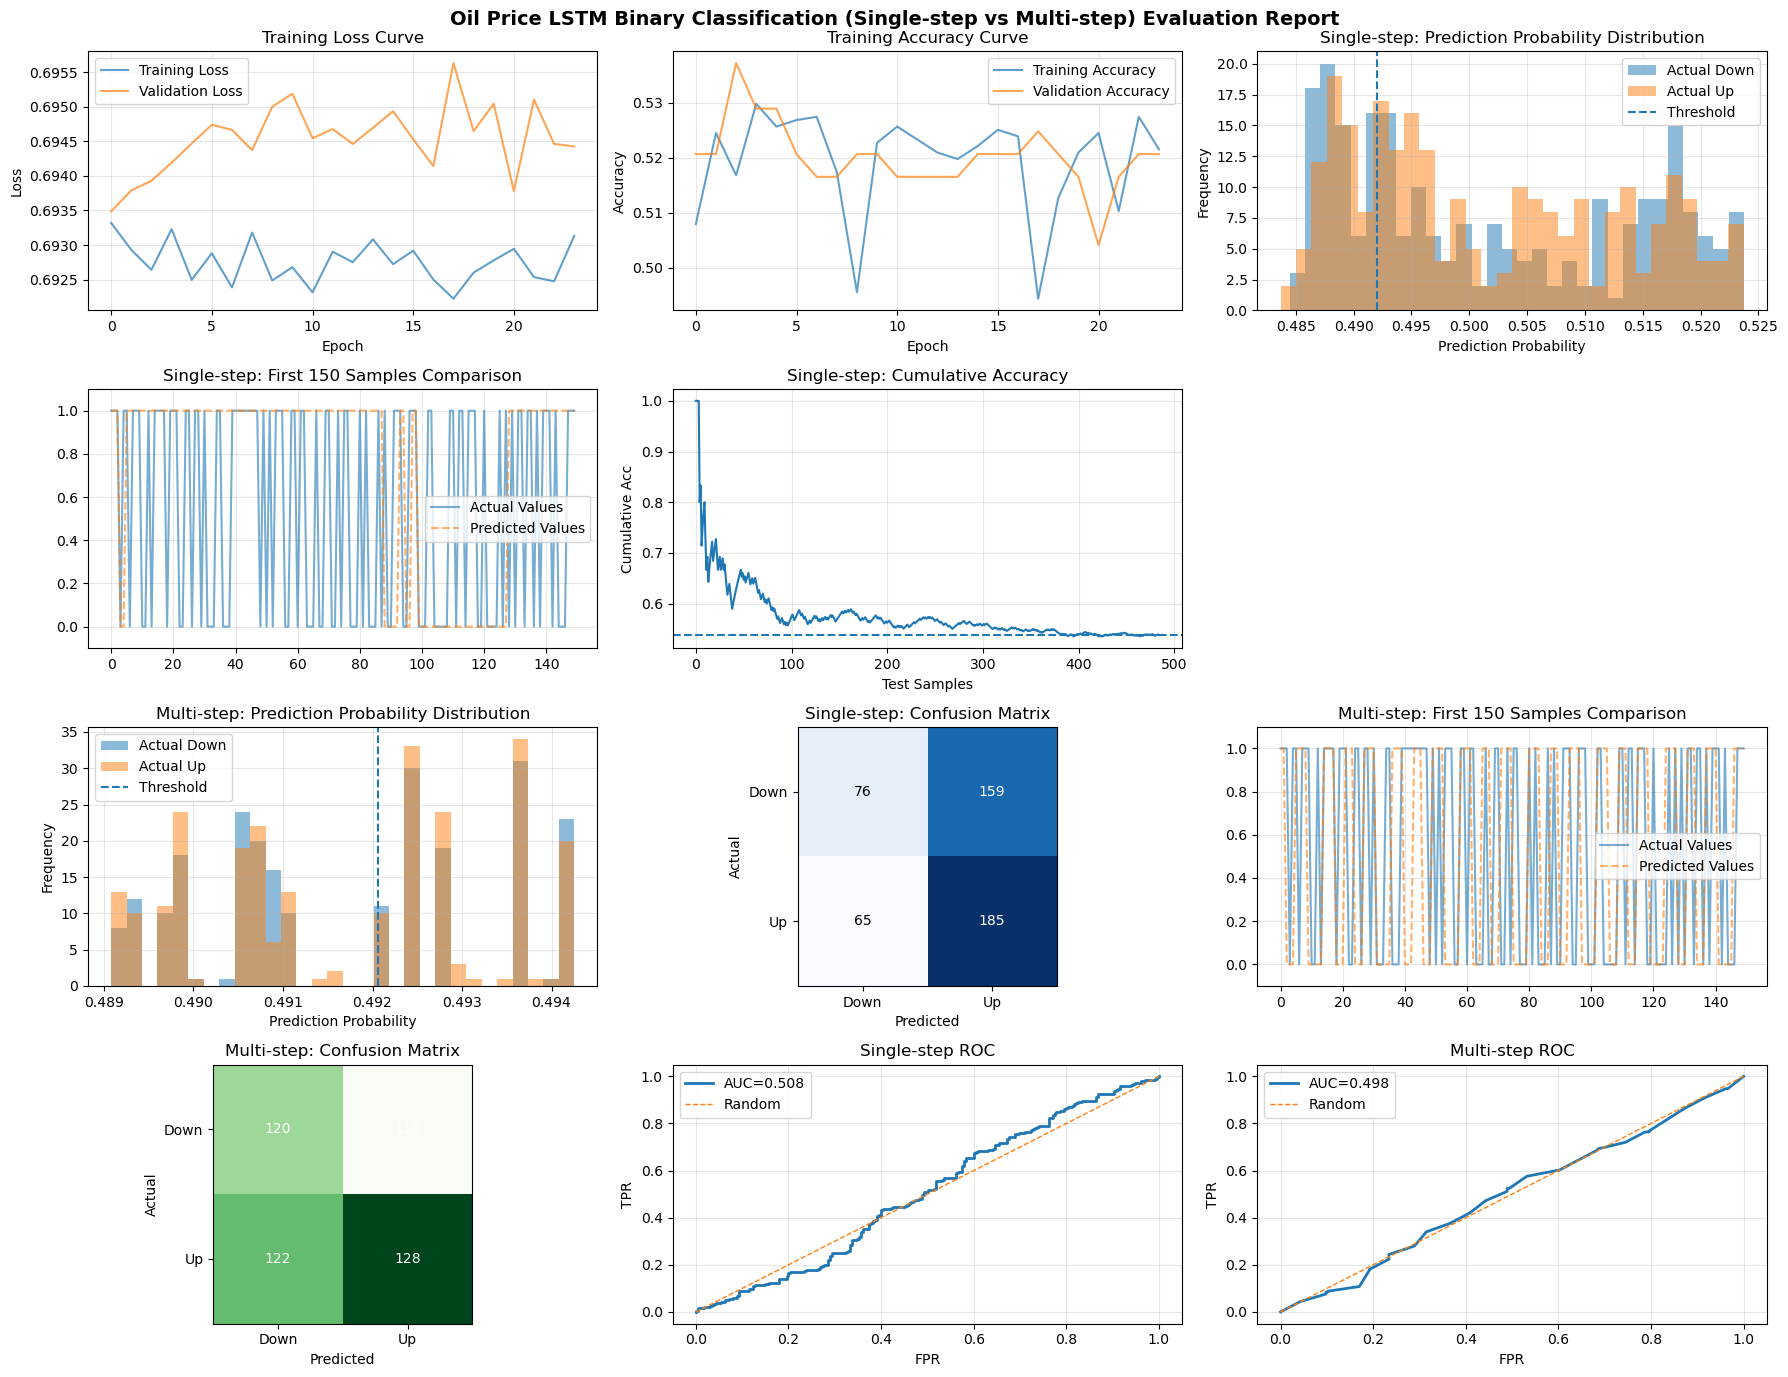


Analysis Summary
Single-step (teacher forcing) accuracy: 0.5381
Multi-step (free-running) accuracy: 0.5113
Threshold: Learned from validation set best_threshold=0.492
Prediction distribution (single-step): Up 70.9%, Down 29.1%

Analysis completed! (Validation/Test leakage fixed)


In [6]:
# single_lstm_oil_prediction_step1.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# =====================
# Device and Random Seed
# =====================
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# =====================
# Dataset Wrapper
# =====================
class EnhancedOilPriceDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.as_tensor(X, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

# =====================
# Unidirectional LSTM Model
# =====================
class StandardLSTMClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=False
        )
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(32, 1)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name and param.data.dim() > 1:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.constant_(param.data, 0)

    def forward(self, x):
        x = self.norm(x)
        lstm_out, _ = self.lstm(x)           # (B, T, H)
        ctx = lstm_out.mean(dim=1)           # Mean Pooling
        h = torch.relu(self.fc1(ctx))
        h = self.dropout1(h)
        logits = self.fc2(h).squeeze(-1)     # (B,)
        return logits

# =====================
# Predictor
# =====================
class ImprovedOilPriceLSTMPredictor:
    def __init__(self, data_path='oil_price_cleaned.csv'):
        self.data_path = data_path
        self.feature_scaler = StandardScaler()
        self.model = None
        self.seq_length = 20
        self.horizon = 1
        self.min_move = 0.0005    # Daily log return threshold
        self.device = device
        self.best_threshold = 0.5
        self.class_weights = torch.tensor([1.0, 1.0], dtype=torch.float32, device=self.device)
        self.ret_amp_scaled = None

    # ---------- Feature Engineering (3 features) ----------
    def create_technical_features(self, prices):
        p = pd.Series(np.asarray(prices).flatten())
        ret_1d = np.log(p).diff()
        ma5 = p.rolling(5, min_periods=1).mean()
        ma20 = p.rolling(20, min_periods=1).mean()
        ma_ratio = (ma5 / (ma20 + 1e-9)) - 1.0
        vol_10 = ret_1d.rolling(10, min_periods=1).std()
        df = pd.DataFrame({
            'ret_1d': ret_1d.fillna(0.0),
            'ma_ratio': ma_ratio.fillna(0.0),
            'vol_10': vol_10.fillna(0.0)
        })
        return df.values

    # ---------- Data Loading/Preprocessing ----------
    def load_and_preprocess_data(self):
        df = pd.read_csv(self.data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)

        logp = np.log(df['Price'])
        ret = logp.diff()
        fut_ret_1 = ret.shift(-1)
        df['Price_Change'] = np.where(
            fut_ret_1 > self.min_move, 1,
            np.where(fut_ret_1 < -self.min_move, 0, np.nan)
        )

        n_up = (df['Price_Change'] == 1).sum()
        n_down = (df['Price_Change'] == 0).sum()
        n_nan = df['Price_Change'].isna().sum()

        print(f"Data shape: {df.shape}")
        print(f"Price range: {df['Price'].min():.2f} - {df['Price'].max():.2f}")
        print(f"Up samples: {n_up}, Down samples: {n_down}, Small moves/No labels: {n_nan}")
        return df

    def create_sequences(self, features, labels, seq_length):
        X, y = [], []
        skipped = 0
        for i in range(seq_length, len(features)):
            if np.isnan(labels[i]):
                skipped += 1
                continue
            X.append(features[i-seq_length:i])
            y.append(int(labels[i]))
        if skipped:
            print(f"Skipped {skipped} small moves/unlabeled samples (|future {self.horizon}-day return| ≤ {self.min_move:.3%})")
        return np.array(X), np.array(y)

    # ========= Important change: Three-way split (train/val/test) and only fit scaler on train =========
    def prepare_data(self, df, train_ratio=0.7, val_ratio=0.1):
        print("Creating simplified features (3)...")
        feats = self.create_technical_features(df['Price'].values)   # (N,3) unnormalized
        labels = df['Price_Change'].values

        n = min(len(feats), len(labels))
        feats, labels = feats[:n], labels[:n]

        # Time-ordered indexing
        split_train = int(n * train_ratio)
        split_val   = int(n * (train_ratio + val_ratio))

        # Only fit scaler on training segment (avoid leakage)
        self.feature_scaler.fit(feats[:split_train])
        feats_scaled = self.feature_scaler.transform(feats)

        # Sequencing
        X, y = self.create_sequences(feats_scaled, labels, self.seq_length)

        # Split into train/val/test based on sequence count
        N = len(X)
        tr = int(N * train_ratio)
        va = int(N * (train_ratio + val_ratio))
        X_train, y_train = X[:tr], y[:tr]
        X_val,   y_val   = X[tr:va], y[tr:va]
        X_test,  y_test  = X[va:],   y[va:]

        # Class weights (only using training segment)
        cw = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        self.class_weights = torch.tensor(cw, dtype=torch.float32, device=self.device)

        # "Typical daily amplitude" for free-running (standardized)
        ret_abs_med = np.median(np.abs(feats[:split_train, 0]))
        self.ret_amp_scaled = (ret_abs_med - self.feature_scaler.mean_[0]) / self.feature_scaler.scale_[0]

        print("\nData preparation completed:")
        print(f"Number of features: {X.shape[2]} (ret_1d, ma_ratio, vol_10)")
        print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
        print(f"Validation set: X_val   {X_val.shape},   y_val   {y_val.shape}")
        print(f"Test set: X_test  {X_test.shape},  y_test  {y_test.shape}")
        print(f"Training set class distribution - Up: {y_train.mean()*100:.1f}%, Down: {(1-y_train.mean())*100:.1f}%")
        print(f"Class weights: Down={self.class_weights[0]:.2f}, Up={self.class_weights[1]:.2f}")
        return X_train, X_val, X_test, y_train, y_val, y_test, feats_scaled

    # ---------- Baseline Evaluation (No Deep Learning) ----------
    def quick_baselines(self, df, X_train, y_train, X_test, y_test):
        print("—— Baseline Evaluation (No Deep Learning) ——")
        train_size = len(y_train)
        test_size = len(y_test)
        # Naive: Predict up if yesterday was up (shifted by one day)
        ret1 = df['Price'].pct_change()
        naive = (ret1.shift(1) > 0).astype(int).values
        naive_slice = naive[self.seq_length:][train_size + (len(df)-len(naive)) : ]  # Safe slicing
        naive_slice = naive[self.seq_length:][train_size: train_size + test_size]
        if len(naive_slice) == test_size:
            print(f"Baseline-Previous day up trend acc: {accuracy_score(y_test, naive_slice):.3f}")
        # MA5>MA20 crossover, shifted by one day
        ma5 = df['Price'].rolling(5).mean()
        ma20 = df['Price'].rolling(20).mean()
        ma_pred = (ma5 > ma20).shift(1).fillna(0).astype(int).values
        ma_slice = ma_pred[self.seq_length:][train_size: train_size + test_size]
        if len(ma_slice) == test_size:
            print(f"Baseline-MA5>MA20 acc: {accuracy_score(y_test, ma_slice):.3f}")
        # Logistic Regression: Only last frame features
        try:
            clf = LogisticRegression(max_iter=1000, class_weight='balanced')
            clf.fit(X_train[:, -1, :], y_train)
            lr_pred = clf.predict(X_test[:, -1, :])
            print(f"Baseline-LogReg(last frame) acc: {accuracy_score(y_test, lr_pred):.3f}")
        except Exception as e:
            print(f"LogReg baseline failed: {e}")

    # ========= Important change: Only use validation set for early stopping and threshold =========
    def train_model(self, X_train, y_train, X_val, y_val, epochs=60, batch_size=32, learning_rate=3e-3):
        train_dataset = EnhancedOilPriceDataset(X_train, y_train)
        val_dataset   = EnhancedOilPriceDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

        input_size = X_train.shape[2]
        self.model = StandardLSTMClassifier(
            input_size=input_size, hidden_size=64, num_layers=1, dropout=0.1
        ).to(self.device)

        criterion = nn.BCEWithLogitsLoss(reduction='none')
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=learning_rate, epochs=epochs, steps_per_epoch=len(train_loader)
        )

        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        best_val_acc = 0.0
        patience = 20
        patience_counter = 0
        best_model_state = None
        best_threshold = 0.5

        print("\nStarting training (using validation set for early stopping and threshold selection)...")
        print("-" * 60)

        from sklearn.metrics import roc_curve

        for epoch in range(epochs):
            # ----- Training -----
            self.model.train()
            total_loss, total_n = 0.0, 0
            train_preds, train_labels = [], []

            for batch_X, batch_y in train_loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                optimizer.zero_grad()
                logits = self.model(batch_X)
                per_sample_loss = criterion(logits, batch_y)
                w = torch.where(batch_y == 1, self.class_weights[1], self.class_weights[0])
                loss = (per_sample_loss * w).mean()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

                total_loss += loss.item() * batch_X.size(0)
                total_n += batch_X.size(0)

                probs = torch.sigmoid(logits)
                train_preds.extend((probs > 0.5).detach().cpu().numpy())
                train_labels.extend(batch_y.detach().cpu().numpy())

            avg_train_loss = total_loss / max(total_n, 1)
            train_acc = accuracy_score(train_labels, train_preds)

            # ----- Validation -----
            self.model.eval()
            val_loss, val_n = 0.0, 0
            val_labels_all, val_probs_all = [], []

            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    batch_X = batch_X.to(self.device)
                    batch_y = batch_y.to(self.device)
                    logits = self.model(batch_X)
                    per_sample_loss = criterion(logits, batch_y)
                    loss = per_sample_loss.mean()

                    val_loss += loss.item() * batch_X.size(0)
                    val_n += batch_X.size(0)

                    probs = torch.sigmoid(logits).detach().cpu().numpy()
                    val_probs_all.extend(probs)
                    val_labels_all.extend(batch_y.detach().cpu().numpy())

            avg_val_loss = val_loss / max(val_n, 1)
            val_labels_all = np.array(val_labels_all)
            val_probs_all = np.array(val_probs_all)

            # Threshold selection using Youden's J on validation set only
            fpr, tpr, th = roc_curve(val_labels_all, val_probs_all)
            j_scores = tpr - fpr
            idx = int(np.nanargmax(j_scores))
            curr_threshold = float(th[idx]) if np.isfinite(th[idx]) else 0.5

            val_preds = (val_probs_all > curr_threshold).astype(int)
            val_acc = accuracy_score(val_labels_all, val_preds)
            val_pred_ratio = val_preds.mean() if len(val_preds) else 0.5

            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_acc)

            # Choose best model based on validation set only
            if (val_acc > best_val_acc) and (0.2 < val_pred_ratio < 0.8):
                best_val_acc = val_acc
                best_threshold = curr_threshold
                best_model_state = {k: v.cpu() for k, v in self.model.state_dict().items()}
                patience_counter = 0
            else:
                patience_counter += 1

            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(
                    f"Epoch [{epoch+1}/{epochs}] - "
                    f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                    f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Curr Thr: {curr_threshold:.3f} | "
                    f"Pred Ratio: {val_pred_ratio:.2f}"
                )

            if patience_counter >= patience:
                print(f"\nEarly stopping: Validation set did not improve for {patience} epochs")
                break

        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            self.best_threshold = float(best_threshold)
            self.model.to(self.device)
            print(f"Restored best model (Val Acc: {best_val_acc:.4f}, Threshold: {self.best_threshold:.3f})")
        else:
            self.best_threshold = float(curr_threshold)
            print(f"No better checkpoint found, using current threshold: {self.best_threshold:.3f}")

        print("-" * 60)
        print("Training completed!")
        return history

    # ---------- Single-step (teacher forcing) ----------
    def predict_walk_forward(self, X_test, y_test):
        print("\n" + "="*60)
        print("Single-step evaluation (teacher forcing)...")
        print("="*60)
        self.model.eval()
        predictions, probabilities, actual_labels = [], [], []

        with torch.no_grad():
            for i in range(len(X_test)):
                X_input = torch.as_tensor(X_test[i:i+1], dtype=torch.float32, device=self.device)
                logits = self.model(X_input).squeeze()
                prob = torch.sigmoid(logits).item()
                thr = getattr(self, 'best_threshold', 0.5)
                y_pred = int(prob > thr)

                predictions.append(y_pred)
                probabilities.append(prob)
                actual_labels.append(y_test[i])

                if (i + 1) % 100 == 0 or i == len(X_test) - 1:
                    current_acc = accuracy_score(actual_labels, predictions)
                    pred_ratio = np.mean(predictions)
                    print(f"  Progress: {i+1}/{len(X_test)} - Accuracy: {current_acc:.4f} - Prediction ratio: {pred_ratio:.2f}")

        predictions = np.array(predictions)
        actual_labels = np.array(actual_labels)
        probabilities = np.array(probabilities)

        accuracy = accuracy_score(actual_labels, predictions) if len(actual_labels) else np.nan
        auc = roc_auc_score(actual_labels, probabilities) if len(actual_labels) > 1 else np.nan
        print(f"\nCompleted (teacher forcing)! Acc={accuracy:.4f}, AUC={auc:.4f}")
        return predictions, actual_labels, accuracy, probabilities

    # ---------- Multi-step (free-running) ----------
    def multi_step_prediction(self, X_test, y_test, n_steps=None):
        if n_steps is None:
            n_steps = len(y_test)

        print("\n" + "="*60)
        print(f"Multi-step recursive prediction (free-running, length={n_steps})...")
        print("="*60)

        assert self.ret_amp_scaled is not None, "ret_amp_scaled not initialized, please run prepare_data() first"

        self.model.eval()
        predictions, probabilities, actual_labels = [], [], []

        current_window = X_test[0].copy()

        with torch.no_grad():
            for i in range(n_steps):
                X_input = torch.as_tensor(current_window.reshape(1, self.seq_length, -1),
                                          dtype=torch.float32, device=self.device)
                logits = self.model(X_input).squeeze()
                prob = torch.sigmoid(logits).item()
                thr = getattr(self, 'best_threshold', 0.5)
                y_pred = int(prob > thr)

                predictions.append(y_pred)
                probabilities.append(prob)
                actual_labels.append(y_test[i] if i < len(y_test) else np.nan)

                if i < n_steps - 1:
                    current_window = np.roll(current_window, -1, axis=0)
                    new_last = current_window[-2].copy()
                    new_last[0] = self.ret_amp_scaled if y_pred == 1 else -self.ret_amp_scaled
                    current_window[-1] = new_last

                if (i + 1) % 100 == 0 or i == n_steps - 1:
                    known = np.array(actual_labels)
                    known_mask = ~np.isnan(known)
                    if known_mask.any():
                        acc_now = accuracy_score(known[known_mask], np.array(predictions)[known_mask])
                        print(f"  Progress: {i+1}/{n_steps} - Cumulative Acc: {acc_now:.4f}")

        predictions = np.array(predictions)
        actual_labels = np.array(actual_labels)
        probabilities = np.array(probabilities)

        mask = ~np.isnan(actual_labels)
        if mask.any():
            accuracy = accuracy_score(actual_labels[mask], predictions[mask])
            auc = roc_auc_score(actual_labels[mask], probabilities[mask])
        else:
            accuracy, auc = np.nan, np.nan

        print(f"\nfree-running completed! Acc={accuracy:.4f}, AUC={auc:.4f}")
        return predictions, actual_labels, accuracy, probabilities

    # ---------- Evaluation and Visualization ----------
    def evaluate_and_visualize(self, single_pred, single_actual, single_prob,
                               multi_pred, multi_actual, multi_prob,
                               step_accuracies, history):
        import matplotlib.pyplot as plt
        from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

        print("\n" + "="*60)
        print("Single-step Prediction Detailed Evaluation")
        print("="*60)
        print(classification_report(single_actual, single_pred, target_names=['Down(0)', 'Up(1)']))

        cm_single = confusion_matrix(single_actual, single_pred, labels=[0,1])
        print("Single-step - Confusion Matrix:")
        print(f"       Pred Down  Pred Up")
        print(f"Actual Down   {cm_single[0,0]:4d}    {cm_single[0,1]:4d}")
        print(f"Actual Up     {cm_single[1,0]:4d}    {cm_single[1,1]:4d}")

        multi_actual = np.array(multi_actual)
        multi_pred   = np.array(multi_pred)
        multi_prob   = np.array(multi_prob)
        m_mask = ~np.isnan(multi_actual)

        if m_mask.any():
            m_true = multi_actual[m_mask].astype(int)
            m_pred = multi_pred[m_mask].astype(int)
            m_prob = multi_prob[m_mask].astype(float)

            print("\n" + "="*60)
            print("Multi-step Prediction (free-running) Detailed Evaluation")
            print("="*60)
            print(classification_report(m_true, m_pred, target_names=['Down(0)', 'Up(1)']))
            cm_multi = confusion_matrix(m_true, m_pred, labels=[0,1])
            print("Multi-step - Confusion Matrix:")
            print(f"       Pred Down  Pred Up")
            print(f"Actual Down   {cm_multi[0,0]:4d}    {cm_multi[0,1]:4d}")
            print(f"Actual Up     {cm_multi[1,0]:4d}    {cm_multi[1,1]:4d}")
        else:
            cm_multi = np.array([[0,0],[0,0]])
            print("\nMulti-step Evaluation: No available true labels (n_steps may exceed testable range).")

        fig = plt.figure(figsize=(18, 14))
        ax1 = plt.subplot(4, 3, 1)
        ax1.plot(history['train_loss'], label='Training Loss', alpha=0.7)
        ax1.plot(history['val_loss'], label='Validation Loss', alpha=0.7)
        ax1.set_title('Training Loss Curve'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True, alpha=0.3)

        ax2 = plt.subplot(4, 3, 2)
        ax2.plot(history['train_acc'], label='Training Accuracy', alpha=0.7)
        ax2.plot(history['val_acc'], label='Validation Accuracy', alpha=0.7)
        ax2.set_title('Training Accuracy Curve'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend(); ax2.grid(True, alpha=0.3)

        ax3 = plt.subplot(4, 3, 3)
        ax3.hist(single_prob[single_actual == 0], bins=30, alpha=0.5, label='Actual Down')
        ax3.hist(single_prob[single_actual == 1], bins=30, alpha=0.5, label='Actual Up')
        ax3.axvline(x=getattr(self, 'best_threshold', 0.5), linestyle='--', label='Threshold')
        ax3.set_title('Single-step: Prediction Probability Distribution'); ax3.set_xlabel('Prediction Probability'); ax3.set_ylabel('Frequency'); ax3.legend(); ax3.grid(True, alpha=0.3)

        ax4 = plt.subplot(4, 3, 4)
        sample_size = min(150, len(single_actual))
        x_axis = np.arange(sample_size)
        ax4.plot(x_axis, single_actual[:sample_size], label='Actual Values', alpha=0.6)
        ax4.plot(x_axis, single_pred[:sample_size], '--', label='Predicted Values', alpha=0.6)
        ax4.set_title(f'Single-step: First {sample_size} Samples Comparison'); ax4.set_ylim(-0.1, 1.1); ax4.legend(); ax4.grid(True, alpha=0.3)

        ax5 = plt.subplot(4, 3, 5)
        cumulative_acc = [accuracy_score(single_actual[:i], single_pred[:i]) for i in range(1, len(single_actual)+1)]
        ax5.plot(cumulative_acc); ax5.set_title('Single-step: Cumulative Accuracy'); ax5.set_xlabel('Test Samples'); ax5.set_ylabel('Cumulative Acc'); ax5.axhline(y=cumulative_acc[-1], linestyle='--'); ax5.grid(True, alpha=0.3)

        ax6 = plt.subplot(4, 3, 6)
        ax6.axis('off')

        ax7 = plt.subplot(4, 3, 7)
        if m_mask.any():
            ax7.hist(m_prob[m_true == 0], bins=30, alpha=0.5, label='Actual Down')
            ax7.hist(m_prob[m_true == 1], bins=30, alpha=0.5, label='Actual Up')
            ax7.axvline(x=getattr(self, 'best_threshold', 0.5), linestyle='--', label='Threshold')
            ax7.set_title('Multi-step: Prediction Probability Distribution'); ax7.set_xlabel('Prediction Probability'); ax7.set_ylabel('Frequency'); ax7.legend(); ax7.grid(True, alpha=0.3)
        else:
            ax7.axis('off')

        ax8 = plt.subplot(4, 3, 8)
        im1 = ax8.imshow(cm_single, interpolation='nearest', cmap='Blues')
        ax8.set_title('Single-step: Confusion Matrix'); ax8.set_xlabel('Predicted'); ax8.set_ylabel('Actual'); ax8.set_xticks([0,1]); ax8.set_yticks([0,1]); ax8.set_xticklabels(['Down','Up']); ax8.set_yticklabels(['Down','Up'])
        for i in range(2):
            for j in range(2):
                ax8.text(j, i, str(cm_single[i,j]), ha='center', va='center', color='white' if cm_single[i,j] > cm_single.max()/2 else 'black')

        ax9 = plt.subplot(4, 3, 9)
        if m_mask.any():
            sample_m = min(150, m_true.shape[0])
            xx = np.arange(sample_m)
            ax9.plot(xx, m_true[:sample_m], label='Actual Values', alpha=0.6)
            ax9.plot(xx, m_pred[:sample_m], '--', label='Predicted Values', alpha=0.6)
            ax9.set_title(f'Multi-step: First {sample_m} Samples Comparison'); ax9.set_ylim(-0.1, 1.1); ax9.legend(); ax9.grid(True, alpha=0.3)
        else:
            ax9.axis('off')

        ax10 = plt.subplot(4, 3, 10)
        if m_mask.any():
            im2 = ax10.imshow(cm_multi, interpolation='nearest', cmap='Greens')
            ax10.set_title('Multi-step: Confusion Matrix'); ax10.set_xlabel('Predicted'); ax10.set_ylabel('Actual'); ax10.set_xticks([0,1]); ax10.set_yticks([0,1]); ax10.set_xticklabels(['Down','Up']); ax10.set_yticklabels(['Down','Up'])
            for i in range(2):
                for j in range(2):
                    ax10.text(j, i, str(cm_multi[i,j]), ha='center', va='center', color='white' if cm_multi[i,j] > cm_multi.max()/2 else 'black')
        else:
            ax10.axis('off')

        ax11 = plt.subplot(4, 3, 11)
        fpr_s, tpr_s, _ = roc_curve(single_actual, single_prob)
        roc_auc_s = auc(fpr_s, tpr_s)
        ax11.plot(fpr_s, tpr_s, lw=2, label=f'AUC={roc_auc_s:.3f}')
        ax11.plot([0,1],[0,1],'--', lw=1, label='Random')
        ax11.set_xlabel('FPR'); ax11.set_ylabel('TPR'); ax11.set_title('Single-step ROC'); ax11.legend(); ax11.grid(True, alpha=0.3)

        ax12 = plt.subplot(4, 3, 12)
        if m_mask.any():
            fpr_m, tpr_m, _ = roc_curve(m_true, m_prob)
            roc_auc_m = auc(fpr_m, tpr_m)
            ax12.plot(fpr_m, tpr_m, lw=2, label=f'AUC={roc_auc_m:.3f}')
            ax12.plot([0,1],[0,1],'--', lw=1, label='Random')
            ax12.set_xlabel('FPR'); ax12.set_ylabel('TPR'); ax12.set_title('Multi-step ROC'); ax12.legend(); ax12.grid(True, alpha=0.3)
        else:
            ax12.axis('off')

        plt.suptitle('Oil Price LSTM Binary Classification (Single-step vs Multi-step) Evaluation Report', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        return fig

    # ---------- One-click Run ----------
    def run_complete_analysis(self):
        print("="*60)
        print("Oil Price LSTM Binary Classification: 70/10/20 Time Split | Validation Set Early Stop/Threshold (No Test Leakage)")
        print("="*60)

        # 1. Data
        print("\n1. Loading and preprocessing data...")
        df = self.load_and_preprocess_data()
        # 2. Split+Features
        print("\n2. Preparing training/validation/test data (avoiding leakage)...")
        X_train, X_val, X_test, y_train, y_val, y_test, feats_scaled = self.prepare_data(df)
        # 2.5 Baseline evaluation (only once on test)
        self.quick_baselines(df, X_train, y_train, X_test, y_test)
        # 3. Training (using train+val only)
        print("\n3. Training model...")
        history = self.train_model(X_train, y_train, X_val, y_val,
                                   epochs=60, batch_size=32, learning_rate=3e-3)
        # 4. Single-step (teacher forcing) - evaluate on test only
        print("\n4. Single-step (teacher forcing)")
        walk_pred, walk_actual, walk_acc, walk_prob = self.predict_walk_forward(X_test, y_test)
        # 5. Multi-step (free-running)
        print("\n5. Multi-step (free-running)")
        free_pred, free_actual, free_acc, free_prob = self.multi_step_prediction(X_test, y_test, n_steps=len(y_test))
        # 6. Evaluation and visualization
        print("\n6. Evaluation and visualization...")
        fig = self.evaluate_and_visualize(
            single_pred=walk_pred, single_actual=walk_actual, single_prob=walk_prob,
            multi_pred=free_pred, multi_actual=free_actual, multi_prob=free_prob,
            step_accuracies=np.array([]),
            history=history
        )
        # 7. Summary
        print("\n" + "="*60)
        print("Analysis Summary")
        print("="*60)
        print(f"Single-step (teacher forcing) accuracy: {walk_acc:.4f}")
        print(f"Multi-step (free-running) accuracy: {free_acc:.4f}")
        print(f"Threshold: Learned from validation set best_threshold={self.best_threshold:.3f}")
        print(f"Prediction distribution (single-step): Up {np.mean(walk_pred)*100:.1f}%, Down {(1-np.mean(walk_pred))*100:.1f}%")

        return {
            'model': self.model,
            'single_step': {
                'predictions': walk_pred,
                'probabilities': walk_prob,
                'accuracy': walk_acc
            },
            'multi_step': {
                'predictions': free_pred,
                'probabilities': free_prob,
                'accuracy': free_acc
            },
            'history': history,
            'best_threshold': self.best_threshold,
        }

# =====================
# Main Program
# =====================
if __name__ == "__main__":
    predictor = ImprovedOilPriceLSTMPredictor('oil_price_cleaned.csv')
    results = predictor.run_complete_analysis()
    print("\n" + "="*60)
    print("Analysis completed! (Validation/Test leakage fixed)")
    print("="*60)
